<a href="https://colab.research.google.com/github/JorgeCarmona323/Macrocycle/blob/main/macrocycle_linker_reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def macrocyclize(pep_smi, linker_smiles='BrCc1c(CBr)cccc1'):
    # Convert SMILES to RDKit molecules
    pep    = Chem.MolFromSmiles(pep_smi)
    linker = Chem.MolFromSmiles(linker_smiles)
    if pep is None or linker is None:
        return None

    # Combine peptide and linker
    combined = Chem.CombineMols(pep, linker)
    rw = Chem.RWMol(combined)
    pep_atom_count = pep.GetNumAtoms()

    # 1) Identify the two CH2 carbons adjacent to Br (atomic #35)
    ch2_idxs = []
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 6:  # carbon
            for nb in atom.GetNeighbors():
                if nb.GetAtomicNum() == 35:  # bromine
                    ch2_idxs.append(atom.GetIdx())
    if len(ch2_idxs) != 2:
        return None
    c1, c2 = ch2_idxs

    # 2) Identify bromine atoms to remove
    br_idxs = []
    for c_idx in (c1, c2):
        for nb in rw.GetAtomWithIdx(c_idx).GetNeighbors():
            if nb.GetAtomicNum() == 35:
                br_idxs.append(nb.GetIdx())

    # 3) Find two S atoms in the peptide (atomic #16, one H)
    s_idxs = []
    for atom in rw.GetAtoms():
        if (atom.GetAtomicNum() == 16 and atom.GetTotalNumHs() == 1
            and atom.GetIdx() < pep_atom_count):
            s_idxs.append(atom.GetIdx())
    if len(s_idxs) < 2:
        return None
    s1, s2 = s_idxs[:2]

    # 4) Add thioether bonds
    rw.AddBond(s1, c1, Chem.BondType.SINGLE)
    rw.AddBond(s2, c2, Chem.BondType.SINGLE)

    # 5) Remove bromines
    for idx in sorted(set(br_idxs), reverse=True):
        rw.RemoveAtom(idx)

    # 6) Sanitize and return
    mol = rw.GetMol()
    Chem.SanitizeMol(mol)
    return mol


Stapled Macrocycle SMILES: C#CCCC(=O)N[C@H]1CSCc2ccccc2CSC[C@@H](C(N)=O)NC(=O)[C@H](CS(=O)(=O)O)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O


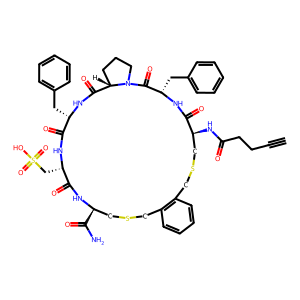

In [ ]:
test_smi = 'C#CCCC(N[C@@H](CS)C(N[C@@H](Cc1ccccc1)C(N(CCC1)[C@@H]1C(N[C@@H](Cc1ccccc1)C(N[C@@H](CS(O)(=O)=O)C(N[C@@H](CS)C(N)=O)=O)=O)=O)=O)=O)=O'
macro = macrocyclize(test_smi)
if macro:
    print("Stapled Macrocycle SMILES:", Chem.MolToSmiles(macro, True))
    display(Draw.MolToImage(macro, size=(300,300)))
else:
    print("❗ No macrocycle formed. Check your SMILES have exactly two free –SH groups.")


In [ ]:
pep_path = '/content/drive/MyDrive/Peptides.smi'
out_path = '/content/drive/MyDrive/Monomer_products.smi'

with open(pep_path) as inf, open(out_path, 'w') as outf:
    for line in inf:
        smi = line.strip()
        if not smi:
            continue
        mol = macrocyclize(smi)
        if mol:
            outf.write(Chem.MolToSmiles(mol, True) + '\n')

print("✅ Enumeration complete. Results saved to:", out_path)


✅ Enumeration complete. Results saved to: /content/drive/MyDrive/Monomer_products.smi
